# Importing Libraries

In [3]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation

In [4]:
Features = pd.read_csv('features.csv')
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.283226,0.739174,0.760110,0.738748,0.712194,0.687986,0.667279,0.694000,0.742275,0.762594,...,4.312694e-06,3.293364e-06,2.149553e-06,2.260914e-06,4.562520e-06,4.985617e-06,1.324619e-06,1.469305e-07,3.053402e-09,neutral
1,0.313458,0.808534,0.815785,0.801600,0.811263,0.810384,0.701737,0.686432,0.732139,0.773171,...,4.248159e-05,4.227043e-05,4.042705e-05,4.220554e-05,4.244403e-05,4.471563e-05,4.213340e-05,3.988319e-05,4.167597e-05,neutral
2,0.181467,0.629995,0.730929,0.743651,0.680889,0.670727,0.673700,0.669033,0.709932,0.745144,...,8.582505e-07,9.570446e-07,7.741540e-07,5.212421e-07,3.252106e-07,4.883136e-07,2.353670e-07,2.240905e-08,9.753157e-11,neutral
3,0.254530,0.676571,0.724970,0.725722,0.668644,0.645344,0.671471,0.631493,0.681748,0.709889,...,6.987414e-06,7.038922e-06,6.659573e-06,6.937638e-06,1.117492e-05,5.767251e-06,2.024577e-06,1.944936e-07,2.701240e-09,neutral
4,0.298656,0.741645,0.776832,0.798077,0.765295,0.766245,0.749681,0.644871,0.680389,0.721996,...,3.322473e-05,3.455279e-05,3.445932e-05,3.374917e-05,3.851392e-05,3.347631e-05,3.140907e-05,2.855921e-05,2.809926e-05,neutral


In [5]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [6]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [7]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [8]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [9]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modelling

In [10]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [11]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 5s 5ms/step - loss: 1.7324 - accuracy: 0.3052 - val_loss: 1.4826 - val_accuracy: 0.4075 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 2s 5ms/step - loss: 1.4576 - accuracy: 0.4165 - val_loss: 1.2981 - val_accuracy: 0.4776 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 2s 5ms/step - loss: 1.3484 - accuracy: 0.4599 - val_loss: 1.2635 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 2s 5ms/step - loss: 1.2929 - accuracy: 0.4857 - val_loss: 1.2351 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 2s 5ms/step - loss: 1.2583 - accuracy: 0.5010 - val_loss: 1.1872 - val_accuracy: 0.5249 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 2s 5ms/step - loss: 1.2236 - accuracy: 0.5078 - val_loss: 1.1822 - val_accuracy: 0.5301 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 2s 5ms/step - lo

286/286 [==============================] - 1s 3ms/step - loss: 1.1283 - accuracy: 0.6089
Accuracy of our model on test data :  60.88576912879944 %


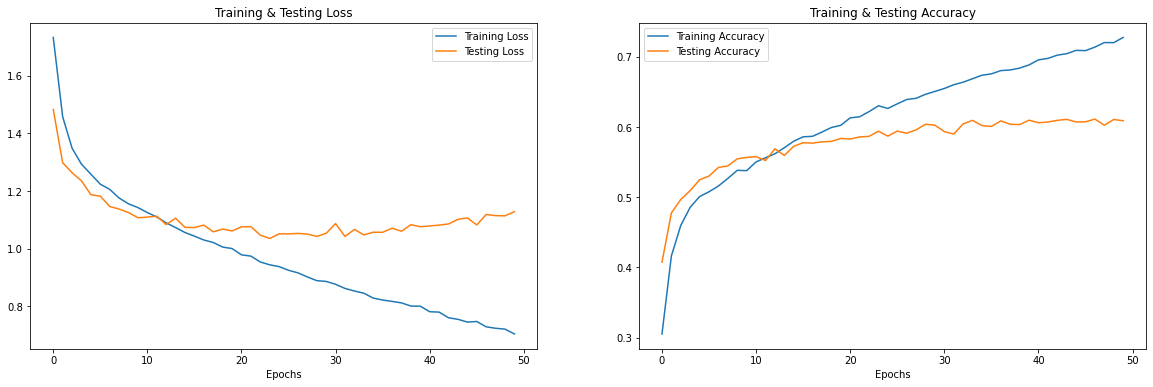

In [12]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [13]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 1s 2ms/step


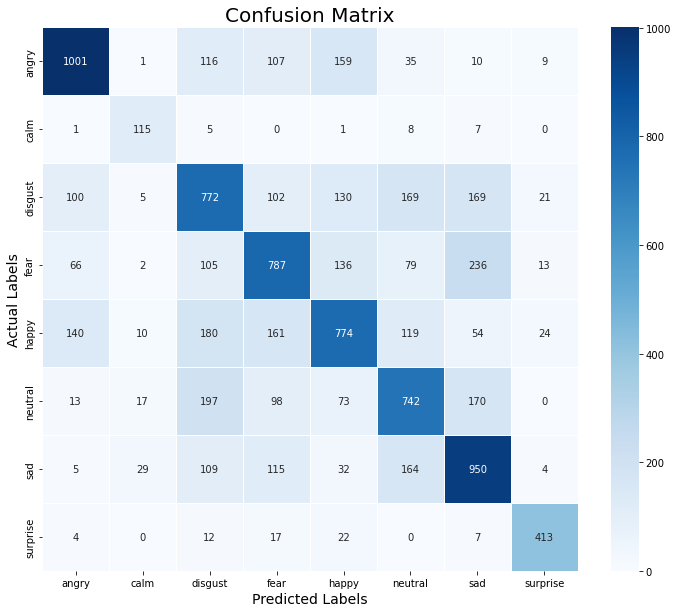

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.70      0.72      1438
        calm       0.64      0.84      0.73       137
     disgust       0.52      0.53      0.52      1468
        fear       0.57      0.55      0.56      1424
       happy       0.58      0.53      0.56      1462
     neutral       0.56      0.57      0.57      1310
         sad       0.59      0.67      0.63      1408
    surprise       0.85      0.87      0.86       475

    accuracy                           0.61      9122
   macro avg       0.63      0.66      0.64      9122
weighted avg       0.61      0.61      0.61      9122

